# Linear Zoo

This notebook shows some of the very strange ways that "lines of best fit" apply to a simple toy data set.

Here's the dataset:

In [1]:
dataset = [
    (1,3),
    (2,6),
    (3,4),
    (4,12),
    (5,5),
    (6,13)
]

The idea is pretty simple: you take some data, and you use some algorithm to find a gradient and
coefficient that best fits that data.

But what do you mean by best? And what algorithm do you want to choose?

In [2]:
import numpy
import fractions

class Unimplemented(Exception):
    pass

class LinearModel:
    def __init__(self):
        self._gradient = None
        self._y_intercept = None
        self._predictions = []
        self._residuals = []
        self._residual_impact = []
        self._overall_metric = None
        
        self._y_values = self.reshape_y([t[1] for t in dataset])
        self._raw_x_values = [t[0] for t in dataset]
        self._x_values = self.reshape_x(self._raw_x_values)
        
        self.fit()
        
        for (x,y) in dataset:
            this_prediction = self.predict(x)
            self._predictions.append(this_prediction)
            self._residuals.append(y - this_prediction)
            self._residual_impact.append(self.measure(y - this_prediction))
            
        self._overall_metric = self.aggregate_metrics(self._residual_impact)
        
    def reshape_y(self, values):
        return values[:]
    
    def reshape_x(self, values):
        return values[:]
            
    def predict(self, x):
        y = self._gradient * x + self._y_intercept
        return y
        
    def formula(self):
        floating_point_coefficients = False
        fractional_coefficients = False
        gradient_term = ""
        if self._gradient == 0.0:
            pass
        elif type(self._gradient) in [type(0.0), numpy.float64]:
            gradient_term = f"{self._gradient:.3f} x"
        elif type(self._gradient) == fractions.Fraction and self._gradient.denominator != 1:
            if self._gradient.numerator == 1:
                gradient_term = f"x / {self._gradient.denominator}"
            else:
                gradient_term = f"{self._gradient.numerator} x / {self._gradient.denominator}"
        else:
            gradient_term = f"{self._gradient} x"
            
        intercept_term = ""
        if self._y_intercept == 0.0:
            if gradient_term == "":
                return "y = 0"
            return f"y = {gradient_term}"
        if type(self._y_intercept) in [type(0.0), numpy.float64]:
            intercept_term = f"{self._y_intercept:.3f}"
        else:
            intercept_term = f"{self._y_intercept}"
            
        if gradient_term == "":
            return f"y = {intercept_term}"
        return f"y = {gradient_term} + {intercept_term}"
        
    def plot(self, ax, **kwargs):
        t = self.title()
        s = self.formula()
        ax.axline((0, float(self._y_intercept)), slope=float(self._gradient), 
                  label=f"{t}: {s}",**kwargs)
        
    def fit(self):
        """This is where you implement the line-of-best fit algorithm. It 
        needs to set self._gradient and self._y_intercept"""
        raise Unimplemented

    def measure(self, residual):
        """How bad is this residual?"""
        raise Unimplemented
        
    def aggregate_metrics(self, residual_measures):
        """How bad is this collection of residuals?"""
        raise Unimplemented
        
    def title(self):
        """What's the name of this algorithm for finding a best line?"""
        raise Unimplemented      
        
    def measure_latex_prefix(self):
        """When we make a table out of this model, what do we put before the y - \hat{y}?"""
        return Unimplemented
    def measure_latex_postfix(self):
        """What do we put after the y - \hat{y}?"""
        return Unimplemented

scikit learn has a large number of useful linear regression functions. They all need the x values to be a numpy
array (or pandas DataFrame). They don't need the y values to be a numpy array, but it's conventional.

I've said that they all use $r^2$ as a measure, which isn't completely true. But subclasses can override this.

Among the many things I haven't put in here that are interesting are:
 
- Huber is very robust to outliers (more so even than RANSAC). I could do this, but it would just be another line
somewhere between the ordinary least squares line and the Siegel one.

- GLMs (generalised linear models) using link functions. This would make sense if the noise in the dataset followed
some special distribution, or if the relationship wasn't quite linear.

In [ ]:
import sklearn.linear_model
import pandas

class SklearnModel(LinearModel):
    def __init__(self):
        LinearModel.__init__(self)
    def reshape_y(self, values):
        return pandas.Series(values)
    def reshape_x(self, values):
        return pandas.DataFrame({'x': pandas.Series(values)})
    def measure(self, residual):
        return residual ** 2
    def aggregate_metrics(self, residual_measures):
        return sum(residual_measures)
    def measure_latex_prefix(self):
        return r'\left('
    def measure_latex_postfix(self):
        return r'\right)^2'
    

## Ordinary Least Squares

This is the one you learned about at school and in statistics class. Plain and simple: minimise the sum
of squared residuals. It works because you can calculate the residuals as a function of (gradient and intercept).
This function turns out to be convex, so a little bit of calculus and you can find the minimum. Every data point
affects the outcome, so every outlier nudges the line a little. You will almost always end up with real-valued
gradient and intercept.

In [ ]:
class OLS(SklearnModel):
    def __init__(self):
        SklearnModel.__init__(self)
    def title(self): return "Ordinary least squares regression (minimise the sum of r^2)"
    def fit(self):
        ols = sklearn.linear_model.LinearRegression()
        ols.fit(self._x_values, self._y_values)
        self._gradient = ols.coef_[0]
        self._y_intercept = ols.intercept_
       

## Theil-Sen

My absolute favourite linear model. Take a pair of points at random, draw a line through them. Then take another
pair of points at random and draw a line through them. Repeat this process as many times as you want, depending
on the accuracy you want. Take the line with the median gradient.

Beautifully robust to outliers. Scales to very large datasets. Can be done by hand or in your head. Falls apart a bit when you have a lot of dimensions though.

In [ ]:
 class TheilSen(SklearnModel):
    def __init__(self):
        SklearnModel.__init__(self)
    def title(self): return "Theil-Sen (median gradient of point pairs)"
    def fit(self):
        ts = sklearn.linear_model.TheilSenRegressor()
        ts.fit(self._x_values, self._y_values)
        self._gradient = ts.coef_[0]
        self._y_intercept = ts.intercept_
 

## RANSAC

Take subsets of points and draw a line through them. Count the number of other points that you are close to. Take another subset of points and draw a line through them and count the number of other points. Keep track of the
maximum so far, and how often you are beating the maximum as you iterate. Stop when you don't think you are going
to get any better.

Even more robust to outliers than Theil-Sen.

In [33]:
class RANSAC(SklearnModel):
    def __init__(self):
        SklearnModel.__init__(self)
    def title(self): return "RANSAC"
    def fit(self):
        rs = sklearn.linear_model.RANSACRegressor()
        rs.fit(self._x_values, self._y_values)
        self._gradient = rs.estimator_.coef_[0]
        self._y_intercept = rs.estimator_.intercept_

## Siegel

For each point, draw a line to every other point, and take the median gradient. Now you have a "best" line through
each point. They have gradients, so take the line with the median gradient.

The most robust-to-outliers method of all linear models. Unfortunately, it only works with one-dimensional $x$ variables, so it isn't part of scikit-learn.

I've kept the $r^2$ residual calculation even though it doesn't make sense here.

In [55]:
class Siegel(LinearModel):
    def __init__(self):
        LinearModel.__init__(self)
    def measure(self, residual):
        return residual ** 2
    def aggregate_metrics(self, residual_measures):
        return sum(residual_measures)
    def title(self):
        return 'Siegel (median of median gradients)'
    def fit(self):
        all_median_gradients = []
        all_median_intercepts = {}
        for i in range(len(self._x_values)):
            x1 = self._x_values[i]
            y1 = self._y_values[i]
            my_gradients = []
            my_intercepts = {}
            for j in range(len(self._x_values)):
                x2 = self._x_values[j]
                y2 = self._y_values[j]
                if x1 == x2:
                    continue
                gradient = (y2-y1) / (x2-x1)
                my_gradients.append(gradient)
                y_intercept = (y2 - x2 * gradient)
                my_intercepts[gradient] = y_intercept
            my_gradients.sort()
            n_lines = len(my_gradients)
            #if n_lines % 2 == 0:
            if False:
                n1 = n_lines // 2 - 1
                n2 = n1 + 1
                grad1 = my_gradients[n1]
                grad2 = my_gradients[n2]
                intercept1 = my_intercepts[grad1]
                intercept2 = my_intercepts[grad2]
                my_median_gradient = (grad1 + grad2) / 2
                my_median_intercept= (intercept1 + intercept2) / 2
            else:
                n1 = n_lines // 2
                my_median_gradient = my_gradients[n1]
                my_median_intercept = my_intercepts[my_median_gradient]
            all_median_gradients.append(my_median_gradient)
            if my_median_gradient in all_median_intercepts:
                all_median_intercepts[my_median_gradient].append(my_median_intercept)
            else:
                all_median_intercepts[my_median_gradient] = [my_median_intercept]
        all_median_gradients.sort()
        n_lines = len(all_median_gradients)
        #if n_lines % 2 == 0:
        if False:
            n1 = n_lines // 2 - 1
            n2 = n1 + 1
            grad1 = all_median_gradients[n1]
            grad2 = all_median_gradients[n2]
            intercept1 = sum(all_median_intercepts[grad1]) / len(all_median_intercepts[grad1])
            intercept2 = sum(all_median_intercepts[grad2]) / len(all_median_intercepts[grad2])
            self._gradient = (grad1 + grad2) / 2
            self._y_intercept = (intercept1 + intercept2) / 2
        else:
            n1 = (n_lines) // 2
            self._gradient = all_median_gradients[n1]
            self._y_intercept = sum(all_median_intercepts[self._gradient]) / len(all_median_intercepts[self._gradient])

'y = 2.000 x + 1.000'

# P-adic regression

Now we get really exotic. What if you don't try to minimise $r^2$, but instead you want to look at whether the
points in the data set have residuals that are highly divisible by a prime? For example, you have bit sequences,
and you want to make sure that the tail of the bit sequences are as long as possible. (e.g. see my paper at AACL-IJCNLP "Number Theory Meets Linguistics: Modelling Noun Pluralisation Across 1497 Languages Using 2-adic Metrics")

I can prove that if you are minimising the sum of p-adic residuals, that the line of best fit must pass through
two of the points in the dataset.

I can't quite prove (but I think it's true) that this is also true if you are trying to minimise the largest
residual. (Because the p-adic metric is an ultrametric, max() is more common than sum().) What I also can't prove
(but think is true) is that one of the max-minimisers will always also minimise the sum.

Anyway, we can brute force our way through finding these lines of best fit. It's only $O(n^3)$ and our dataset is small.

In [ ]:
class PadicModel(LinearModel):
    def __init__(self, prime):
        self._prime = prime
        LinearModel.__init__(self)
    def measure(self, residual):
        (n,d) = residual.as_integer_ratio()
        if n == 0:
            return 0
        if d == 0:
            raise ValueError
        valuation = 0
        while n % self._prime == 0:
            valuation += 1
            n = n // self._prime
        while d % self._prime == 0:
            valuation -= 1
            d = d // self._prime
        return fractions.Fraction(1, self._prime) ** valuation
    def measure_latex_prefix(self):
        return r'\left|'
    def measure_latex_postfix(self):
        return r'\right|_' + str(self._prime)
    
    def fit(self):
        best_gradient = None
        best_intercept = None
        best_score = None
        for i in range(len(self._x_values)):
            x1 = self._x_values[i]
            y1 = self._y_values[i]
            for j in range(i+1, len(self._x_values)):
                x2 = self._x_values[j]
                y2 = self._y_values[j]
                if x1 == x2:
                    continue
                gradient = fractions.Fraction(y2-y1, x2-x1)
                y_intercept = fractions.Fraction(y2 - x2 * gradient)
                residuals = []
                residual_sizes = []
                for k in range(len(self._x_values)):
                    x3 = self._x_values[k]
                    y3 = self._y_values[k]
                    prediction = gradient * x3 + y_intercept
                    residuals.append(prediction - y3)
                    residual_sizes.append(self.measure(prediction - y3))
                overall = self.aggregate_metrics(residual_sizes)
                if best_score is None or overall < best_score:
                    best_gradient = gradient
                    best_intercept = y_intercept
                    best_score = overall
        self._gradient = best_gradient
        self._y_intercept = best_intercept
   

In [ ]:
class PadicLinearSumMinimizer(PadicModel):
    def __init__(self, prime):
        PadicModel.__init__(self, prime)
    def aggregate_metrics(self, residual_measures):
        return sum(residual_measures)
    def title(self):
        return f'Minimise sum of {self._prime}-adic residuals'

Note what I said above, I'm not sure if this is guaranteed to get the right answer.

In [56]:
class PadicLinearMaxMinimizer(PadicModel):
    def __init__(self, prime):
        PadicModel.__init__(self, prime)
    def aggregate_metrics(self, residual_measures):
        return max(residual_measures)
    def title(self):
        return f'Minimise max of {self._prime}-adic residuals'

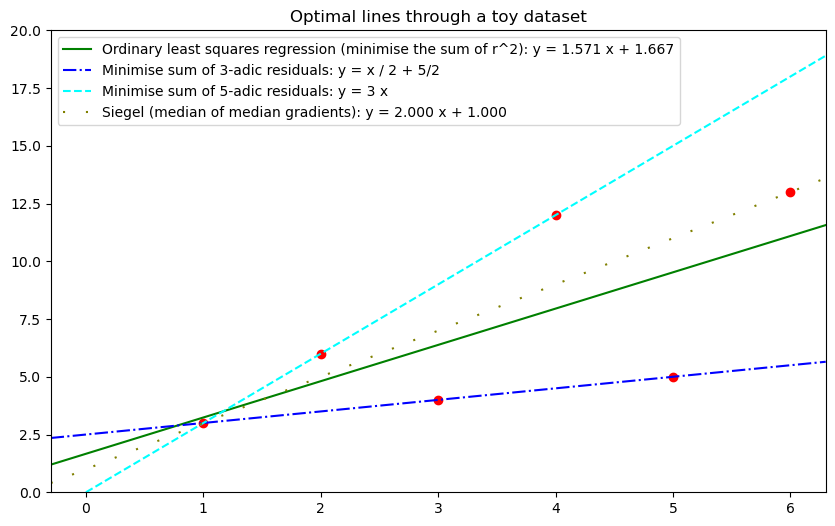

In [57]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(figsize=(10,6))
ax.set_ylim((0,20))
ax.scatter(x=[t[0] for t in dataset], y=[t[1] for t in dataset], c="red")
ols = OLS()
ols.plot(ax=ax, c="green")
p3 = PadicLinearSumMinimizer(3)
p3.plot(ax=ax, c="blue", linestyle="-.")
p5 = PadicLinearSumMinimizer(5)
p5.plot(ax=ax, c="cyan", linestyle="--")
siegel = Siegel()
siegel.plot(ax=ax, c="olive", linestyle=(0,(1,10)))

# Feel free to uncomment these... they are nice, but they just add noise to the diagram that starts
# to get overwhelming.

#ts = TheilSen()
#ts.plot(ax=ax, c="purple",linestyle=":")
#rs = RANSAC()
#rs.plot(ax=ax, c="orange",linestyle="-.")

ax.legend()
ax.set_title("Optimal lines through a toy dataset")
fig.savefig("toydata-regression.png")
None

In [59]:
def nice_format(v):
    if type(v) == fractions.Fraction:
        if v.denominator == 1:
            return str(v)
        return r'\frac{' + f"{v.numerator}" + '}{' + f'{v.denominator}' + '}'
    if type(v) in [type(0.0), numpy.float64]:
        return f"{v:.3f}"
    return str(v)

def latex_table(*models):
    output = r'\renewcommand{\arraystretch}{1.5}' + '\n'
    output += r'\begin{tabular}{|rr|'
    output += '|'.join(['rrr' for m in models])
    output += '|}\n'
    output += r'\hline' + '\n'
    output += ' & & '
    model_titles = ['\\multicolumn{3}{p{4cm}|}{' + m.title().replace('r^2', '$r^2$') + '}' for m in models]
    output += ' & '.join(model_titles)
    output += r'\\' + '\n ' + r'\multicolumn{2}{|l|}{\bf Line} & '
    model_formulas = ['\\multicolumn{3}{l|}{$' + m.formula().replace('y', r'\hat{y}') + '$}' for m in models]
    output += " & ".join(model_formulas)
    output += r'\\' + '\n'
    output += r'\hline' + '\n'
    output += '$x$ & $y$ &'
    middle_terms = [r'$\hat{y}$ & $\hat{y}-y$ & $' + m.measure_latex_prefix() + '\hat{y}-y' + m.measure_latex_postfix() + '$' for m in models]
    output += ' & '.join(middle_terms)
    output += r'\\' + '\n'
    for i in range(len(dataset)):
        (x,y) = dataset[i]
        output += f'{x} & {y} & '
        values = []
        for m in models:
            values.append(nice_format(m._predictions[i]))
            values.append(nice_format(m._residuals[i]))
            values.append(nice_format(m._residual_impact[i]))
        output += '$'
        output += '$ & $'.join(values)
        output += r'$\\' + '\n'
    output += r'\hline' + '\n'
    output += r'\multicolumn{2}{|l|}{\bf Aggregate} & '
    values = []
    for m in models:
        values.append('')
        values.append('')
        total = nice_format(m._overall_metric)
        values.append('$' + total + '$')
    output += ' & '.join(values)
    output += r'\\' + '\n' + r'\hline'
    output += r'\end{tabular}' + '\n'
    output += r'\renewcommand{\arraystretch}{1}' + '\n'
    return output

Showing the reg

In [60]:
print(latex_table(ols, p3, p5))

\renewcommand{\arraystretch}{1.5}
\begin{tabular}{|rr|rrr|rrr|rrr|}
\hline
 & & \multicolumn{3}{p{4cm}|}{Ordinary least squares regression (minimise the sum of $r^2$)} & \multicolumn{3}{p{4cm}|}{Minimise sum of 3-adic residuals} & \multicolumn{3}{p{4cm}|}{Minimise sum of 5-adic residuals}\\
 \multicolumn{2}{|l|}{\bf Line} & \multicolumn{3}{l|}{$\hat{y} = 1.571 x + 1.667$} & \multicolumn{3}{l|}{$\hat{y} = x / 2 + 5/2$} & \multicolumn{3}{l|}{$\hat{y} = 3 x$}\\
\hline
$x$ & $y$ &$\hat{y}$ & $\hat{y}-y$ & $\left(\hat{y}-y\right)^2$ & $\hat{y}$ & $\hat{y}-y$ & $\left|\hat{y}-y\right|_3$ & $\hat{y}$ & $\hat{y}-y$ & $\left|\hat{y}-y\right|_5$\\
1 & 3 & $3.238$ & $-0.238$ & $0.057$ & $3$ & $0$ & $0$ & $3$ & $0$ & $0$\\
2 & 6 & $4.810$ & $1.190$ & $1.417$ & $\frac{7}{2}$ & $\frac{5}{2}$ & $1$ & $6$ & $0$ & $0$\\
3 & 4 & $6.381$ & $-2.381$ & $5.669$ & $4$ & $0$ & $0$ & $9$ & $-5$ & $\frac{1}{5}$\\
4 & 12 & $7.952$ & $4.048$ & $16.383$ & $\frac{9}{2}$ & $\frac{15}{2}$ & $\frac{1}{3}$ & $12$ & $0$

In [61]:
with open('toydata-data.tex', 'w') as f:
    f.write(latex_table(ols,p3,p5))